# Interpretation of Shapley values

In this chapter you'll learn:

- correct interpretation of Shapley values
- pitfalls for interpretation
- interpretation for many special cases
-


TODO: Look at examples here: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression


## Shapley values for linear models

In [322]:
import shap
from sklearn.linear_model import LinearRegression
X,y = shap.datasets.california(n_points=3000)
background = shap.utils.sample(X, 2000)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Alright, now we have a linear regression model.
Let's first inspect the coefficients and then compare it with the corresponding Shapley values.

In [323]:
import pandas as pd
coefs = pd.DataFrame({"feature": X.columns.values, "value": model.coef_})
print(coefs)

      feature     value
0      MedInc  0.457325
1    HouseAge  0.009440
2    AveRooms -0.140501
3   AveBedrms  1.105387
4  Population  0.000005
5    AveOccup -0.003361
6    Latitude -0.418640
7   Longitude -0.437567


In [324]:
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(X)

Exact explainer: 3001it [00:15, 66.83it/s]                                                   


Alright, now let's plot the feature "MedInc" against its shapley values.

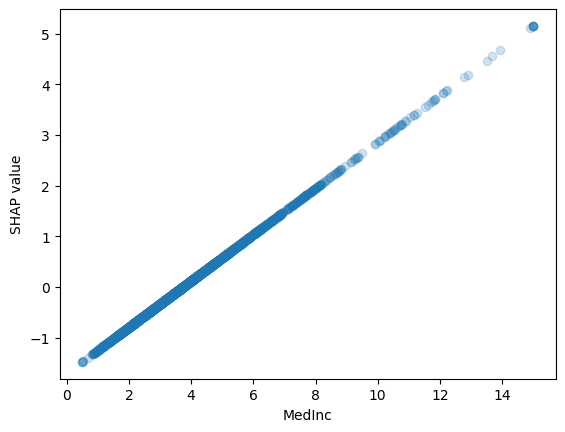

In [325]:
import matplotlib.pyplot as plt
# select one feature for plotting SHAP values
feature_name = 'MedInc'
feature_idx = X.columns.get_loc(feature_name)

# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')
plt.show()

So we can see that the Shapley value increases linearly with each increase in the feature. And this increase is exactly the same as the slope in 

In [326]:
coefs.value[feature_idx]

0.45732460121985236

In [327]:
model.intercept_

-37.81505214409206

We know that in linear regression models, $\phi_{ji}(\hat{f}) = \beta_j x_j - E(\beta_jX_j) = \beta_j (x_j - E(X_j))$
Let's confirm that this is correct:

In [328]:
X[feature_name].mean()

3.8714374666666664

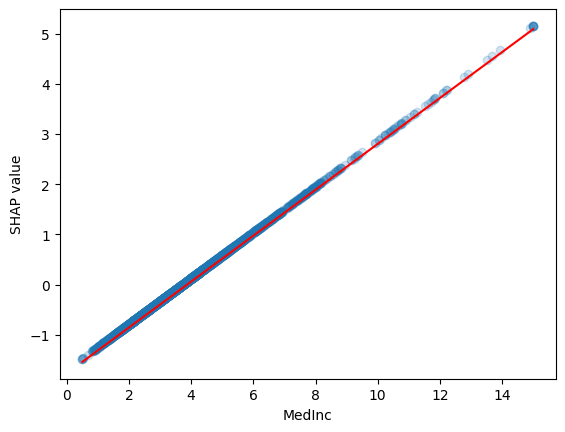

In [329]:
import numpy as np
# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values.values[:, feature_idx], alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')

x_range = np.array([X[feature_name].min(), X[feature_name].max()])

plt.plot(x_range, coefs.value[feature_idx] * (x_range - X[feature_name].mean()), color='red')

plt.show()

Looking good, and within an estimation error.

This gives us a first amount of trust in the method.

So we know that when

- the model is additive
- the effects are linear

then the Shapley values are the model coefficient multiplied with the actual feature value minus some constant.
This product is also called the feature effect for an instance.
Because the coefficient alone couldn't tell us how important a feature was for a particular instance. Because it also depends on the actual feature value: if it is large, in absolute terms, then the contribution to the outcome will be much larger than when the value is near zero.
The constant simply adjusts the values towards the mean effect, so that the plot is centered around the *expected feature effect*.

## Shapley values for additive models

In this next step, we allow the relation between a feature and the target to be non-linear.
We don't, however, allow interactions between the features.
Additive models with non-linear base functions are perfectly modeled with so-called generalized additive models, also called GAMs.


A GAM models y in the following way:

$$\hat{f}(x) = \beta_0 + \beta_1 f_1(x_1) + \ldots + f_p(x_p)$$

The difference to the simple linear model is that we allow the functions $f_j$. If these are the identity function for all features, namely $f_j(x_j) = x_j$, then we again come out with the linear model.
So linear regression models are special cases of GAMs.

But with GAMs, we can now have arbitrary functions for the features.
A popular choice are spline functions which allow for rather flexible shapes of functions that are still smooth and have a gradient.

Educationally, to understand Shapley values, they are perfect, because they allow us to study what happens with non-linear functions, but without interactions.
Because only with interactions will the interpretation become trickier.

So we go back to the same example and fit a GAM instead of a linear regression model.

For this we rely on the interpret Python library. YOu can install it with:

In [330]:
!pip install interpret

Then we train the model:

TODO: Rewrite that code

First we fit a model.
It's an explainable boosting regressor from the interpet package

::: .{callout-note}

From the docs: https://interpret.ml/docs/ebm.html

Explainable Boosting Machine (EBM) is a tree-based, cyclic gradient boosting Generalized Additive Model with automatic interaction detection. EBMs are often as accurate as state-of-the-art blackbox models while remaining completely interpretable. Although EBMs are often slower to train than other modern algorithms, EBMs are extremely compact and fast at prediction time.

TODO: Turn into quote, or say in own words

:::

In [331]:
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

ExplainableBoostingRegressor(interactions=0)

Next, we produce the Shapley values values

In [332]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, background)
shap_values_ebm = explainer_ebm(X)

The question now: How do the Shapley values look like?
And does it match what we would expect?

But first we have to define what we expect.
Since the model is a GAM (TODO: check out ExplainableBoostingRegressor and add details here), we know what the dependence of the target on a feature look like.

We can simply visualize this with the following code:


In [333]:
model_ebm.explain_global?

In [334]:
from interpret import show
ebm_global = model_ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/11452697472/ -->

Text(0, 0.5, 'SHAP value')

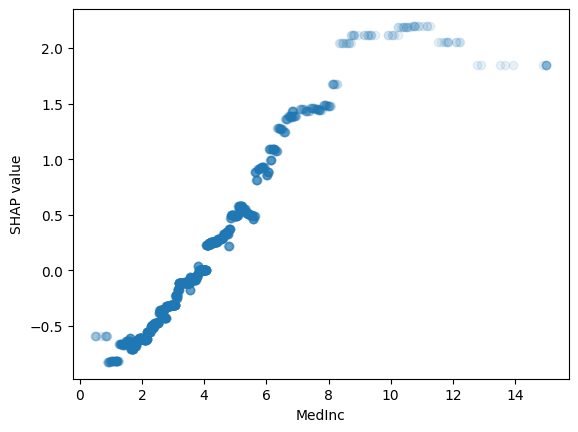

In [335]:
# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values_ebm.values[:, feature_idx], alpha=0.1)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')

In [336]:
X.iloc[0]

MedInc           1.388200
HouseAge        15.000000
AveRooms         3.929530
AveBedrms        1.100671
Population    1024.000000
AveOccup         3.436242
Latitude        32.800000
Longitude     -115.560000
Name: 2732, dtype: float64

In [337]:
X.iloc[0]

MedInc           1.388200
HouseAge        15.000000
AveRooms         3.929530
AveBedrms        1.100671
Population    1024.000000
AveOccup         3.436242
Latitude        32.800000
Longitude     -115.560000
Name: 2732, dtype: float64

In [338]:
first_row = X.iloc[np.repeat(0, 100)]
# create the MedInc column with values ranging from min(MedInc) to max(MedInc) on an equidistant grid
MedIncRange = np.linspace(X['MedInc'].min(), X['MedInc'].max(), num=100)
first_row['MedInc'] = MedIncRange
# print the new DataFrame
print(first_row)

         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
2732   0.499900      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.646367      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.792833      15.0   3.92953   1.100671      1024.0  3.436242   
2732   0.939300      15.0   3.92953   1.100671      1024.0  3.436242   
2732   1.085767      15.0   3.92953   1.100671      1024.0  3.436242   
...         ...       ...       ...        ...         ...       ...   
2732  14.414233      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.560700      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.707167      15.0   3.92953   1.100671      1024.0  3.436242   
2732  14.853633      15.0   3.92953   1.100671      1024.0  3.436242   
2732  15.000100      15.0   3.92953   1.100671      1024.0  3.436242   

      Latitude  Longitude  
2732      32.8    -115.56  
2732      32.8    -115.56  
2732      32.8    -115.56  
2732      32.8    -115.

/var/folders/5q/m5yfk63j7293f91h2f1zj8j00000gn/T/ipykernel_93534/3726400141.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [339]:
preds = model_ebm.predict(first_row)

TODO: Figure out how to compute the differences in intercept between PDP and SHAP here

In [340]:
correction_factor = 0.68

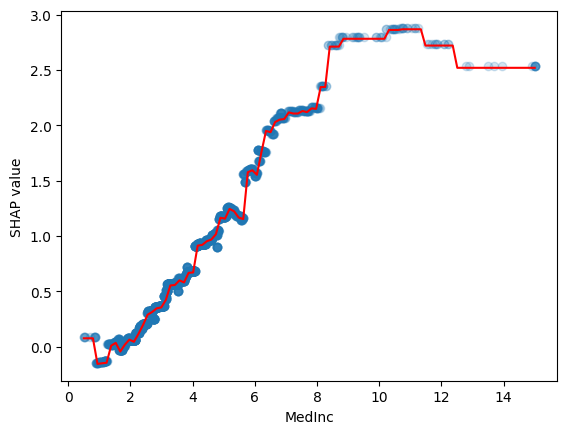

In [341]:
import numpy as np

Xpred = model_ebm.predict(X).mean()

# plot SHAP values against feature values
plt.scatter(X[feature_name], shap_values_ebm.values[:, feature_idx] + correction_factor, alpha=0.2)
plt.xlabel(feature_name)
plt.ylabel('SHAP value')


x0pred = model_ebm.predict(X.iloc[[0]])

plt.plot(MedIncRange, preds - x0pred, color='red')

plt.show()

Again, as you can see, the SHAP values follow the same trajectory as when we would simply change one of the features (here MedInc).
This gives us another boost in the trust of understanding Shapley values.

But things get tricky when we have interactions.

And they get really tricky when we have interactions + correlations.
But manageable (and other interpretation methods have to deal with the same difficulties)

## Shapley values and feature interactions

Goal in this section: Show how Shaplye values are to be interpreted when two features interact.

::: {.callout-note}

## Feature Interaction

Two features interact when the prediction can't be explained by the sum of the feature effects.

:::

A simple example of a model with interactions:

$$f(x) = x_1 + x_2 + x_1 * x_2$$

We can't explain the prediction as a sum of only to feature effects, because we have this term here where both features are "entangled".

What does this mean for shapley values?

Let's go back to the fundamentals:
Shapley values fairly attribute the prediction to the individual features.
Let's walk through the terms in the example above:
x_1 can be attributed to feature 1 of course, same for x_2 to feature 2.
And the effect of the product needs to be fairly split between the features.


Simulate the function f(x1,x2) = x1 + x2 + x1 * x2. Then fit a random forest with sklearn (Python), then explain the predictions with shapley values

First, we need to import the necessary libraries for this task. We will use numpy for numerical computations, pandas for data manipulation, and sklearn for machine learning tasks.


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



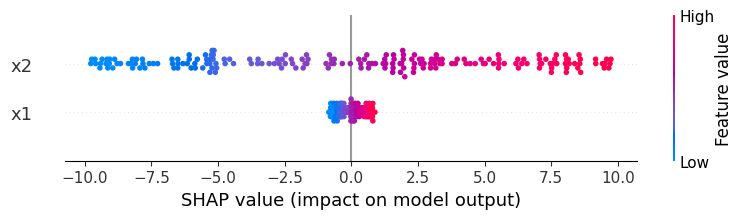

In [342]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

n = 1000

# Create a new dataframe with two columns, x1 and x2
df = pd.DataFrame({'x1': np.random.uniform(-1, 1, n),
                   'x2': np.random.uniform(-10, 10, n)})

# Compute the target variable y
df['y'] = df.x1 + df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

Again, but this time adding the interation

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



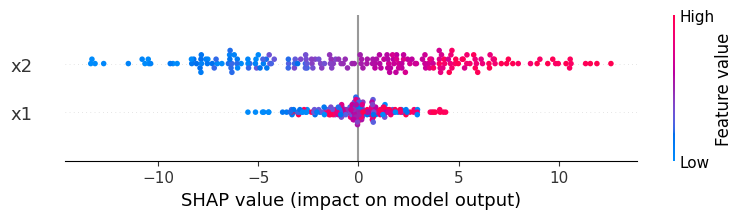

In [343]:
# Compute the target variable y
df['y'] = df.x1 + df.x2 + df.x1 * df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

Second example with interactions. This time only interactions, no 

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



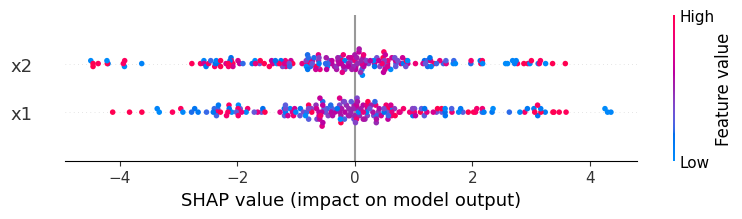

In [344]:
# Compute the target variable y
df['y'] = df.x1 * df.x2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)

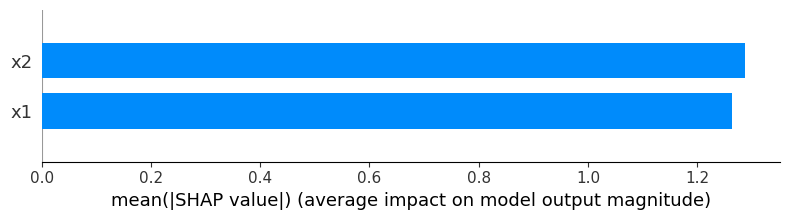

In [345]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The features have the same feature importance!

How can that be?
X1 has a so much bigger range, but otherwise both features have the same role and shape.
Shouldn't X1 be more important?

Let's Play a game. I'll give you a value of X1, and you tell me what information this gives you about the outcome.

What can well say when X2 = 0?

Answer: f(X1, 0) = 0 * X1 = 0. So we know it's always zero.

What can we say when X2 = 9?

Answer: Since X1 can be between -1 and 1, we know that f(x) will be in the range of -9 to 9.

So there is value in knowing X2.

Let's do the same for X1:

If X1 is zero, f(0, X2) = 0 as well.

If X1 is 0.9, we know that $f(0.9, X2) = 0.9 * X2 \in [-9,9]$ because $X_1 \in [-10, 10]$

So we had symmetrical outputs, and even though X2 is on a larger scale, knowing either X1 or X2 gives us the same amount of inferomation.

Whether you like that interpretation or not, that's how Shapley values work for interactions, at least in the case of mulitplication.


In [346]:
# Compute the target variable y
df['y'] = df.x1 + df.x2 + 20 * (df.x1 < -.5) * (df.x2 < -5)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['x1', 'x2']], df.y, test_size=0.2, random_state=42
)

# Train a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

That's what the function looks like

/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



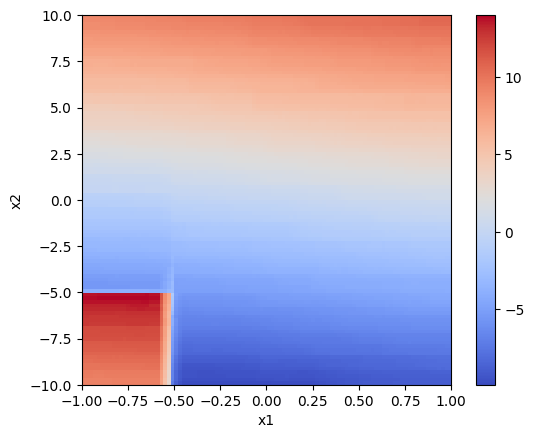

In [347]:
# Generate x1 and x2 grids
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)

# Flatten the grids and predict color
X = np.column_stack((xx1.ravel(), xx2.ravel()))
color = rf_model.predict(X)

# Reshape the predicted color array
color = color.reshape(xx1.shape)

# Plot the heatmap
plt.imshow(color, extent=[x1.min(), x1.max(), x2.min(), x2.max()],
           origin='lower', cmap='coolwarm', aspect = 0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()


/Users/chris/repos/shap-book/manuscript/venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



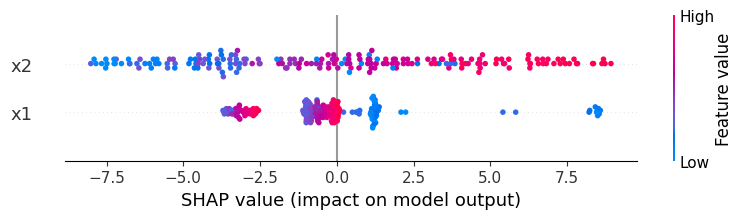

In [348]:
# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Explain the predictions with shapley values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize the shapley values
shap.summary_plot(shap_values, X_test)



## How to interpret the axioms

## Do's and Dont's for interpretation


### Do Consider The Background Data

### Don't Overinterpret an Overfitted Model

- TODO: replicate overfitted model here from pitfalls paper as a teaching lesson
-
-

## Summary for Interpretation

- Features that don't contribute to the model get a contribution of zero
- 
